<a href="https://colab.research.google.com/github/agentydragon/sched/blob/master/Explore_Anki_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib notebook
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import timedelta
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
conn = sqlite3.connect('/content/gdrive/My Drive/collection.anki2')
data = []
for row in conn.execute('SELECT id, cid, ease, time, type FROM revlog;'):
  id, cid, ease, time, type = row
  data.append((pd.Timestamp(id, unit='ms'), cid, ease, time, type))
df = pd.DataFrame(data, columns = ['id', 'cid', 'ease', 'time', 'type'])

Let's get the number of cards I have.

In [6]:
print(len(pd.unique(df['cid'])))

34537


Forgetting curves
==

In [0]:
%matplotlib inline

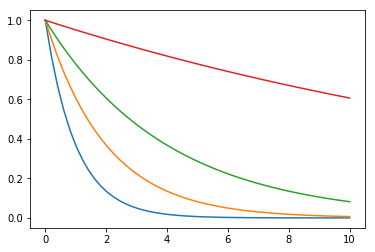

In [12]:
x = np.linspace(0.0, 10.0)
plt.plot(x, np.exp(-x), x, np.exp(-0.5 * x), x, np.exp(-0.25 * x), x, np.exp(-0.05 * x))

In [0]:
def get_card_reviews(cid):
  card_reviews = df[df.cid == cid]
  card_reviews = card_reviews.loc[:, ['id', 'ease', 'time', 'type']]
  card_reviews['correct'] = card_reviews.ease > 1
  card_reviews = card_reviews.loc[:, ['id', 'correct']]
  card_reviews.head()
  card_reviews['diff'] = card_reviews['id'].diff()
  return card_reviews[~card_reviews['diff'].isnull()]

def get_sample_card_ids(n):
  return pd.Series(pd.unique(df['cid'])).sort_values().sample(n=n, random_state=1).to_numpy()

Card difficulty - making lambda smaller/bigger on win/loss
===

Model: probability of getting a card right is $\hat{p} = e^{-\lambda \cdot t}$.
If you get a card right, $\lambda$ gets multiplied by $w$, and if you get it wrong, it gets multiplied by $l$.
The initial value of $\lambda$ is $\lambda_1$. $t$ is measured in floating-point days since last review. Parameters are $[\lambda_1, w, l]$ and they are initialized with ones. To prevent taking logs of numbers very close to 0, we cap $\hat{p}$ between 0.001 and 0.998. Here we try to fit one global model.

We optimize $H(p, \hat{p})$ by stochastic gradient descent. The model is trained on 1000 random cards.

In [0]:
num_cards = 100 #@param {type:"integer"}
epochs = 1000 #@param {type:"integer"}


after round 0 [0.9945055, 0.93423533, 0.97033834] loss= 2.7519743
after round 10 [0.94985366, 0.66264117, 0.9748742] loss= 1.9895054
after round 20 [0.91090345, 0.43794712, 1.0167735] loss= 1.4496759
after round 30 [0.88259596, 0.30348274, 1.0486419] loss= 1.2508247
after round 40 [0.8660628, 0.2434753, 1.0730766] loss= 1.2056427
after round 50 [0.853892, 0.21343252, 1.0952047] loss= 1.1902815
after round 60 [0.84347653, 0.19556598, 1.1166805] loss= 1.1814158
after round 70 [0.8340132, 0.18460307, 1.1382266] loss= 1.1746796
after round 80 [0.82515955, 0.17861727, 1.1603539] loss= 1.1686306
after round 90 [0.8167018, 0.17667276, 1.1836007] loss= 1.1624476
after round 100 [0.8084728, 0.17826156, 1.208644] loss= 1.1554301
after round 110 [0.8003359, 0.18324481, 1.2363651] loss= 1.1467637
after round 120 [0.792171, 0.1916948, 1.267818] loss= 1.1353811
after round 130 [0.78385144, 0.20355752, 1.3039334] loss= 1.1201038
after round 140 [0.77517134, 0.2176452, 1.3444469] loss= 1.1008602
after

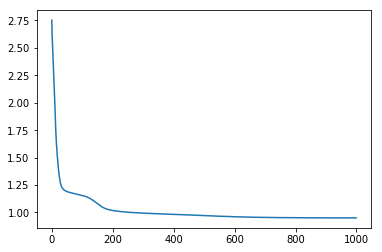

In [28]:
lambda1 = tf.Variable(1.0, name="lambda1", trainable=True)
win_p = tf.Variable(1.0)
loss_p = tf.Variable(1.0)
variables = [lambda1, win_p, loss_p]

l = lambda1
losses = []
probabilities = []

def build_losses_for_reviews(card_reviews):
  l = lambda1
  for index, row in card_reviews.iterrows():
    #print(row)
    diff_seconds = row['diff'].total_seconds()
    diff_days = diff_seconds / 86400.0
    current_probability = 0.998 * tf.exp(-l * diff_days) + 0.001
    probabilities.append(current_probability)

    if row['correct']:
      # we predicted probability current_probability --> if it was 1, do nothing
      loss_bit = -tf.log(current_probability)
      losses.append(loss_bit)
      l = l * win_p
    else:
      loss_bit = -tf.log(1.0 - current_probability)
      losses.append(loss_bit)
      l = l * loss_p
      
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress value='{value}' max='{max}' style='width: 100%'>
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, num_cards), display_id=True)
for i, card in enumerate(get_sample_card_ids(num_cards)):
  build_losses_for_reviews(get_card_reviews(card))
  out.update(progress(i, num_cards))
out.update(HTML("Losses for reviews built."))
  
loss = tf.reduce_sum(losses) / len(losses)
# Making training rate higher than 0.01 leads to shooting out to NaNs.
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = opt.minimize(loss, var_list=variables)

losses = []
values = []

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
 
  epoch_progress = display(progress(0, epochs), display_id=True)
  for i in range(epochs):
    metadata = tf.RunMetadata()
    sess.run(train_op)
    epoch_progress.update(progress(i, epochs))
    vars_value = sess.run(variables)
    loss_value = sess.run(loss)
    if i % 10 == 0:
      print("after round", i, vars_value, "loss=", loss_value)
      values.append(tuple(vars_value + [loss_value]))
    losses.append(loss_value)
  
  print('Final:')
  print(sess.run(variables))
#  print('Probs: ', sess.run(probabilities))
#  print('Loss: ', sess.run(loss))

plt.plot(range(epochs), losses)
    

3D + color plot of the optimization
==

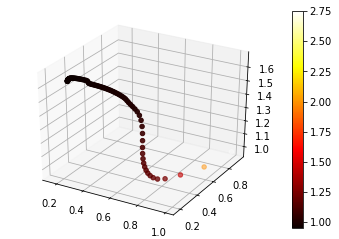

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = list(map(lambda p: p[0], values))
y = list(map(lambda p: p[1], values))
z = list(map(lambda p: p[2], values))
c = list(map(lambda p: p[3], values))

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

One training gave the result: $\lambda_1\approx 0.2016$, $w\approx 0.2432$, $l\approx 1.8975$.

Looks like we are bottoming out at a cross-entropy of about 1.1 on each review. From $-\log(x)=1.1$, we have $x=e^{-1.1}\approx 0.33$. So that's about as much entropy as if we predicted the probability of a true event at $1/3$.

Questions:

* What if I let this run longer?
* Can I do constrained optimization in Tensorflow, so that $\lambda$ in model below is fixed to positive?
* Would other optimizers be faster?

Extension ideas:

* Use softplus or exp to coerce real numbers into positives 
* Would it be useful to model per-card state?
* Compute test-set loss on a withheld set of cards
* Operate on batches; construct one computation graph for one card, do not throw them all into the graph.
* Anki's SR algorithm uses the *interval*, the *card difficulty* and the *number of last successful reviews*. Would integrating the number of last successful reviews into the model help?
* It would be nice to get a visualization of how the probabilities look for a given card, with review points.
* It might be helpful to distinguish between "learn" reviews, "relearn" reviews and others.

Basic model - the same forgetting curve starting after every revision
===

This one currently does not work, and tends to somehow run into NaN's. I should fix that at some point.

In [0]:
lambda1 = tf.Variable(1.0, name="lambda1", trainable=True)
losses = []
probabilities = []

def build_losses_for_reviews(card_reviews):
  l = lambda1
  for index, row in card_reviews.iterrows():
    #print(row)
    diff_seconds = row['diff'].total_seconds()
    diff_days = diff_seconds / 86400.0
    current_probability = 0.9998 * tf.exp(-l * diff_days) + 0.0001
    probabilities.append(current_probability)

    if row['correct']:
      # we predicted probability current_probability --> if it was 1, do nothing
      loss_bit = -tf.log(current_probability)
      losses.append(loss_bit)
    else:
      loss_bit = -tf.log(1.0 - current_probability)
      losses.append(loss_bit)

for card in get_sample_card_ids(10):
  build_losses_for_reviews(get_card_reviews(card))

loss = tf.reduce_sum(losses) / len(losses)
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
variables = [lambda1, lambda2]
train_op = opt.minimize(loss, var_list=variables)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(100):
    loss_value = sess.run(loss)
    if np.isnan(loss_value):
      print('Reached NaN!')
    sess.run(train_op)
    if i % 10 == 0:
      print('Probs: ', sess.run(probabilities))
      print('Loss: ', loss_value)
      print("after round", i, sess.run(variables))
  

Probs:  [0.983854, 0.9731835, 0.6304561, 0.6378329, 0.00010707023, 0.00010000005, 1e-04, 0.9870601, 0.98080695, 0.00013492166, 0.8915018, 0.80357873, 0.11786603, 0.018518459, 0.0012241048, 0.9928614, 0.9825855, 0.33358455, 0.9917703, 0.9197108, 0.83498573, 0.08052481, 0.12274151, 0.062798, 0.0043989536, 0.00038960838, 0.000100002035, 1e-04, 1e-04, 0.9921068, 0.91639555, 1e-04, 1e-04, 1e-04, 0.94125444, 0.52467954, 0.00011422679, 1e-04, 1e-04, 0.99875134, 0.9923497, 0.98533535, 0.018801449, 0.0022194902, 0.000100337245, 1e-04, 1e-04, 0.9986431, 0.69440746, 0.6172623, 0.00010000204, 1e-04, 1e-04, 0.9929457, 0.6246892, 0.00010000494, 1e-04, 1e-04, 0.9922447, 0.95966107, 0.20310037, 0.05310323, 0.000100000056, 1e-04, 1e-04, 0.9995254, 0.9995709, 0.62954056, 0.014662209, 0.00034591663, 0.00010002474, 1e-04, 1e-04, 0.85582453, 0.89602727, 0.8652565, 0.00012321361, 0.992933, 0.99084216, 0.9657137, 0.00010600637, 0.98374814, 0.98277557, 0.15442748, 0.0008701521, 0.00022042947, 0.00010003694, 1